### Required Libraries and Utilities

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve 
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint 

from imblearn.over_sampling import SMOTE
from collections import Counter

#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Utility Functions

### Import Data

In [2]:
heart_faliure_data = pd.read_csv(filepath_or_buffer = 'heart_failure_clinical_records_dataset.csv')

heart_faliure_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
heart_faliure_data.shape

(299, 13)

In [4]:
heart_faliure_data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [5]:
heart_faliure_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


## Data Preparation

### Test - Train Split

In [6]:
X = heart_faliure_data[['age', 'ejection_fraction', 
                        'serum_creatinine', 'serum_sodium', 
                        'platelets', 'creatinine_phosphokinase']]

# X = heart_faliure_data[['age', 'ejection_fraction',
#                         'serum_creatinine', 'serum_sodium']] 

# X = heart_faliure_data.drop(['DEATH_EVENT', 'time'], axis = 1)

# X = heart_faliure_data[['age','ejection_fraction','serum_sodium']]

y = heart_faliure_data[['DEATH_EVENT']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 0.90, 
                                                    test_size = 0.10, 
                                                    random_state = 109)

print("X_Train Shape:", X_train.shape)
print("Y_Train Shape:", y_train.shape)
print("X_Test Shape:", X_test.shape)
print("Y_Test Shape:", y_test.shape)

X_Train Shape: (269, 6)
Y_Train Shape: (269, 1)
X_Test Shape: (30, 6)
Y_Test Shape: (30, 1)


In [7]:
data_features = dict(enumerate(X.columns))
data_features

{0: 'age',
 1: 'ejection_fraction',
 2: 'serum_creatinine',
 3: 'serum_sodium',
 4: 'platelets',
 5: 'creatinine_phosphokinase'}

#### Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
# Implement SMOTE
sampling = SMOTE(random_state = 100)
X_train, y_train = sampling.fit_resample(X_train.values, y_train.values.ravel())
    
# Shuffle the data
perms = np.random.permutation(X_train.shape[0])
X_train = X_train[perms]
y_train = y_train[perms]

X_train = pd.DataFrame(data = X_train)
y_train = pd.DataFrame(data = y_train)

print(X_train.shape)
print(y_train.shape)

(372, 6)
(372, 1)


In [9]:
X_temp = pd.DataFrame(data = X_train)
y_temp = pd.DataFrame(data = y_train)

In [10]:
print('Resampled dataset shape %s' % Counter(y_train.values.ravel()))
print('Test dataset shape %s' % Counter(y_test.values.ravel()))

Resampled dataset shape Counter({1: 186, 0: 186})
Test dataset shape Counter({0: 17, 1: 13})


#### <font color = brown>Data Balancing Significance</font>

**`1. With the application of SMOTE on the training data, the number of 1s (Death Event) are now equal to the number of 0s (Survival Case) with each 171 records respectively.`**

- **2. This will ensure  -**
    - 2.1 There are equal data points for both positive and negative scenarios and we have a balanced dataset.
    - 2.2 The model will not be biased during training phase by seeing more example of Survival scenarios.


### Data Normalization

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X has feature names, but StandardScaler was fitted without feature names


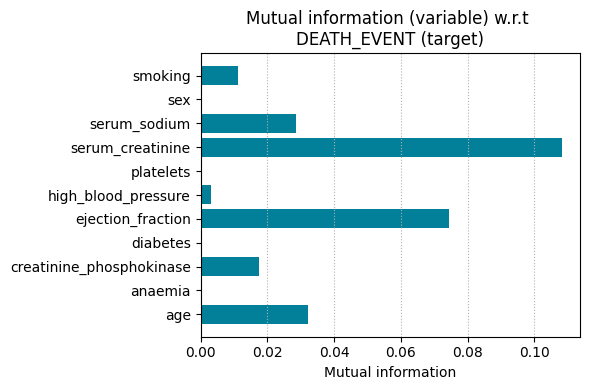

In [12]:
from sklearn.feature_selection import mutual_info_classif

MI_features = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
               'ejection_fraction', 'high_blood_pressure', 'platelets',
               'serum_creatinine', 'serum_sodium', 'sex', 'smoking']

mutual_infos = (mutual_info_classif(X=heart_faliure_data[MI_features],
                                    y=heart_faliure_data["DEATH_EVENT"], 
                                    n_neighbors=20,
                                    discrete_features=[False, False, False, True, False,
                                                     True, False, False, False, True, False],
                                    random_state=42))

plt.figure(figsize=(6, 4))
plt.barh(y=MI_features, width=mutual_infos, color="#038099")
plt.title("Mutual information (variable) w.r.t \nDEATH_EVENT (target)");
plt.xlabel("Mutual information")
plt.gca().xaxis.grid(True, linestyle=':');
plt.tight_layout();

In [13]:
# SVM with Default Parameters and linear kernel
# SVM assigns feature importances with linear kernel.
# coef_ : Weights assigned to the features when kernel="linear".
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.coef_

svm = SVC(kernel = 'linear', probability = True, random_state = 100)
svm = svm.fit(X_train, y_train.values.ravel())

### Feature Importances

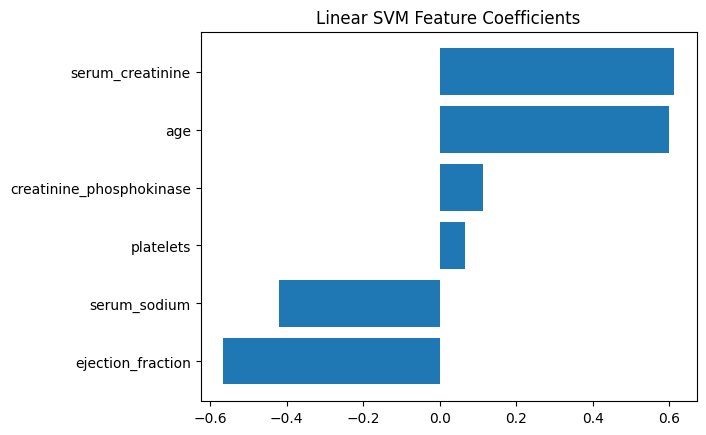

In [14]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title("Linear SVM Feature Coefficients")
    plt.show()

feat_names = list(data_features.values())
f_importances(svm.coef_[0], feat_names)

['age',
 'ejection_fraction',
 'serum_creatinine',
 'serum_sodium',
 'platelets',
 'creatinine_phosphokinase']

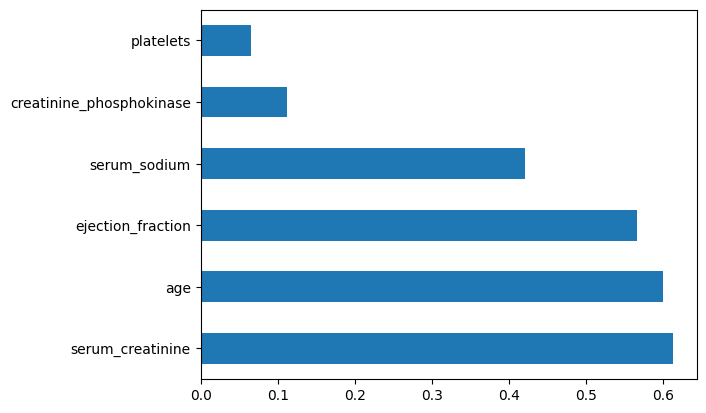

In [15]:
pd.Series(abs(svm.coef_[0]), index=feat_names).nlargest(10).plot(kind='barh')
feat_names

### <font color = Red>Insight:</font>

**serum_creatinine**, **ejection_fraction**, and **age** turn out to be containing the highest amount of information and the death event is highly dependent on these parameters.

## 2. Decision Tree

In [16]:
# GridSearchCV to find the optimal tree parameters
dt1 = tree.DecisionTreeClassifier(random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 30), 
#               "max_features": randint(1, 9), 
              "min_samples_leaf": randint(1, 9),
              "min_samples_split":range(2, 10),
              "criterion": ["gini", "entropy"]}

# Instantiating RandomizedSearchCV object 
tree_grid = RandomizedSearchCV(dt1, param_grid, cv = 5) 
    
# fitting the model for grid search 
tree_grid.fit(X_train, y_train.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", tree_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", tree_grid.best_estimator_) 

Best Parameters: {'criterion': 'gini', 'max_depth': 27, 'min_samples_leaf': 5, 'min_samples_split': 9}

Best Classifier: DecisionTreeClassifier(max_depth=27, min_samples_leaf=5, min_samples_split=9,
                       random_state=100)


## Tree Visualization

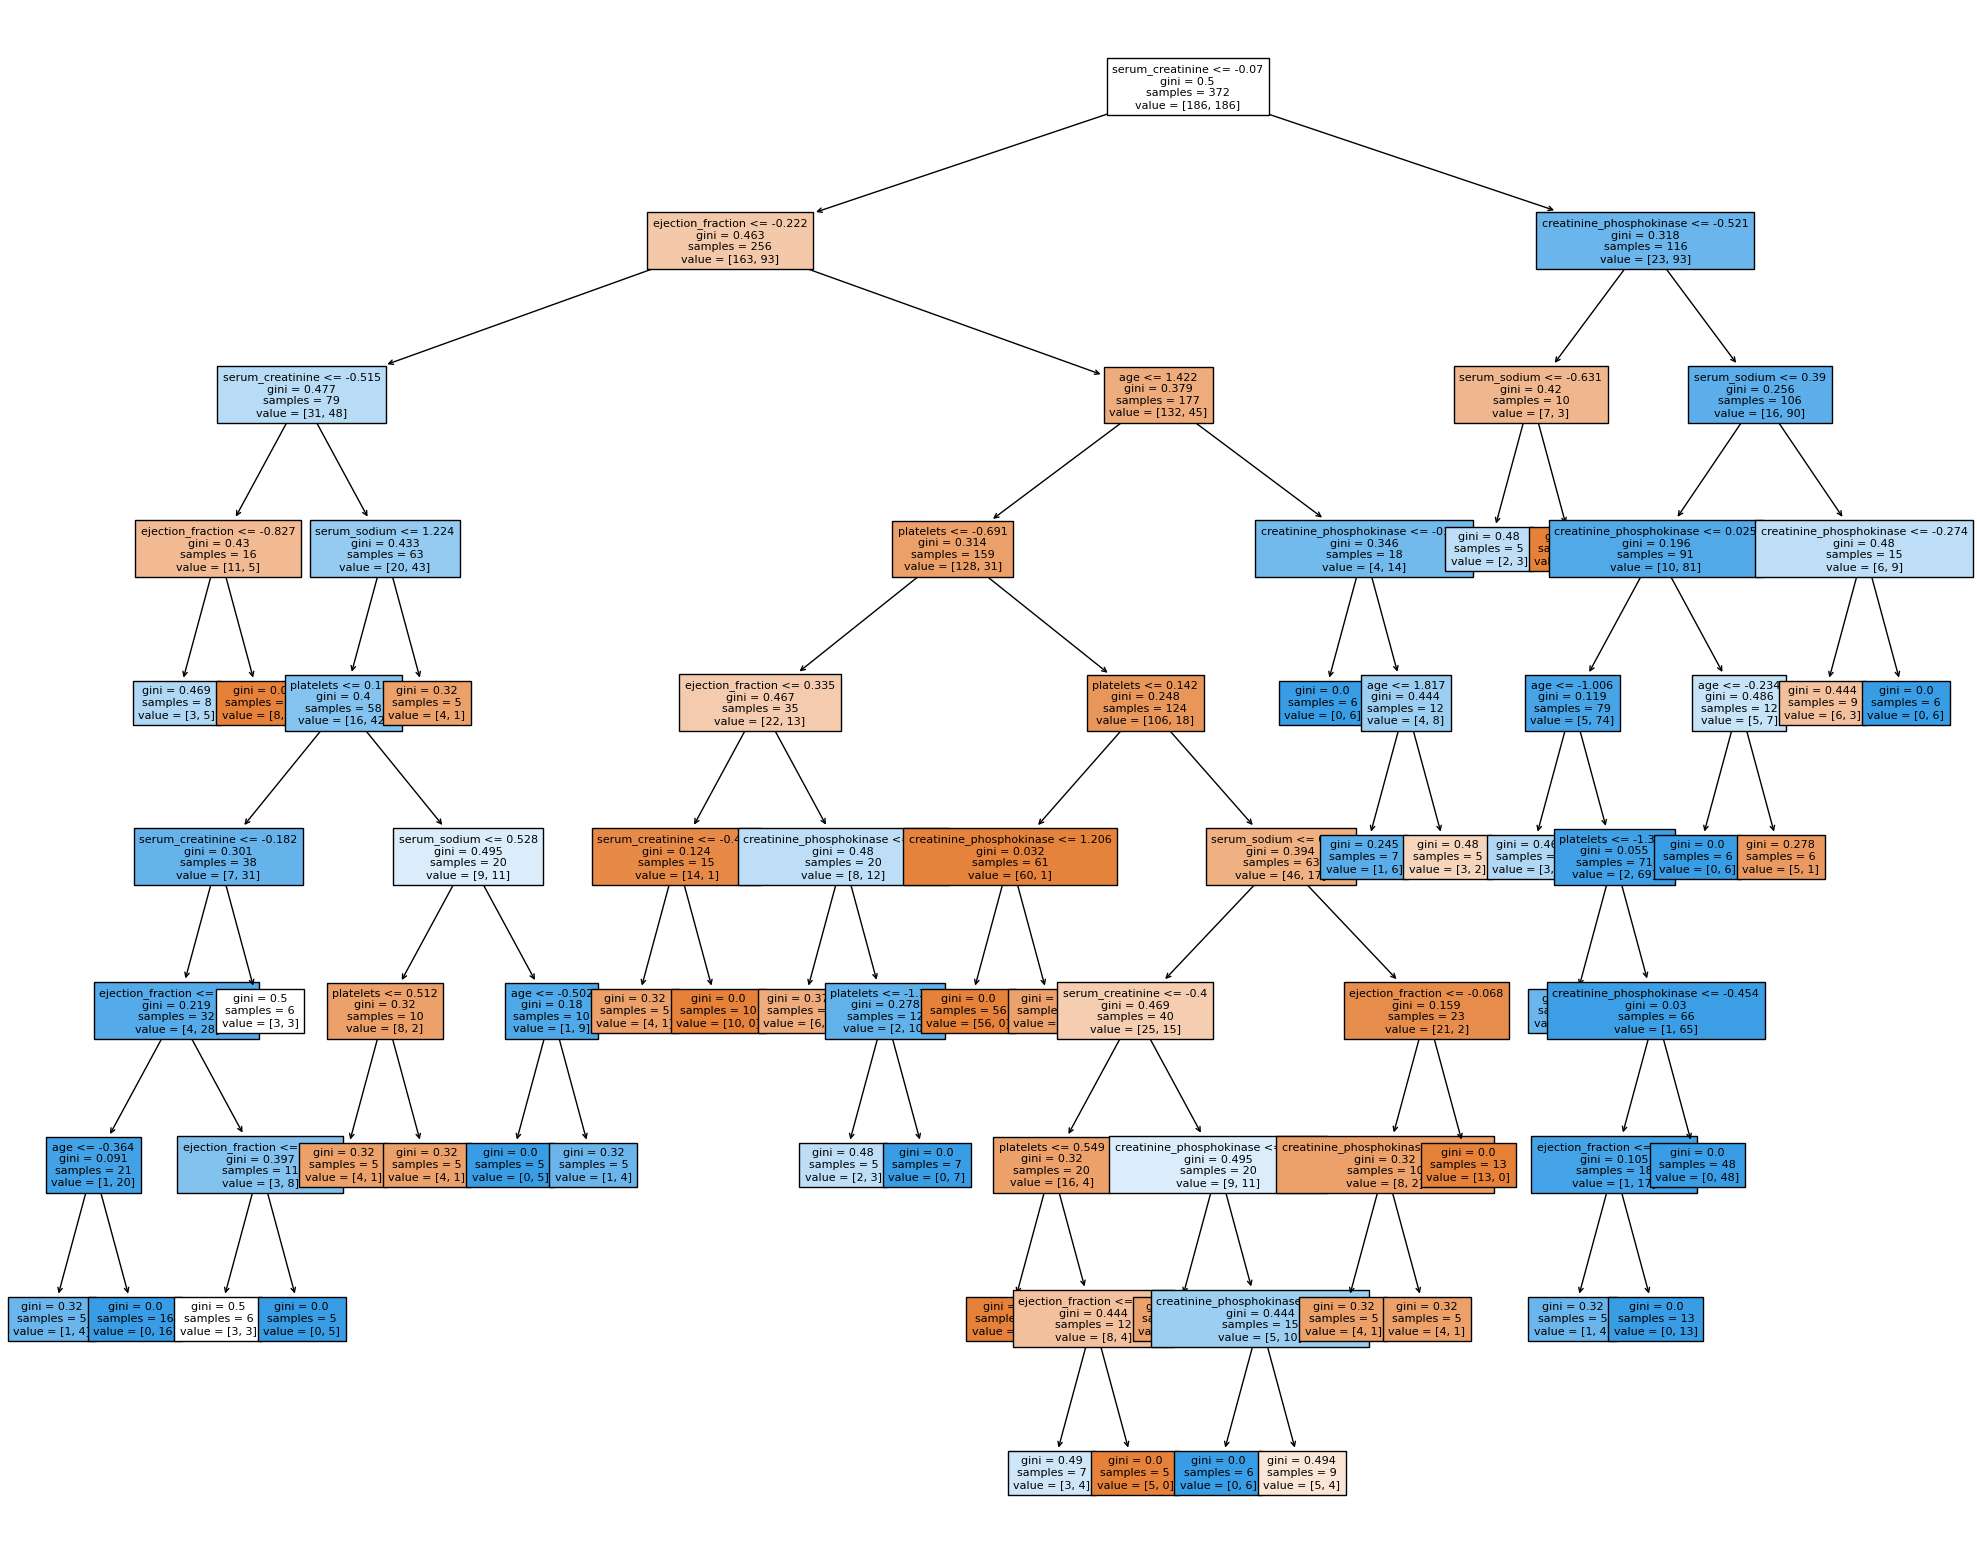

In [17]:
best_tree = tree_grid.best_estimator_

best_tree = best_tree.fit(X_train, y_train.values.ravel())

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_tree, 
                   feature_names=data_features,
                   filled=True, 
                   fontsize=8)

## Feature Importance

Feature: 0, Score: 0.14552
Feature: 1, Score: 0.20636
Feature: 2, Score: 0.29976
Feature: 3, Score: 0.10810
Feature: 4, Score: 0.08561
Feature: 5, Score: 0.15464


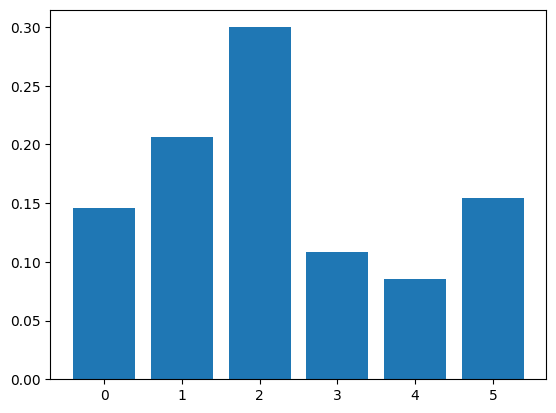

In [19]:

# get importance
importance = best_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## 3. Random Forest

In [20]:
rn_forest = RandomForestClassifier(n_jobs = -1, random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 10), 
#               "max_features": randint(1, 3), 
              "min_samples_leaf": randint(25, 50),
              "min_samples_split":range(50, 100, 2),
              "n_estimators": range(1000, 8000, 500),
              "bootstrap": [True, False]}

# Instantiating RandomizedSearchCV object 
forest_grid = RandomizedSearchCV(rn_forest, param_grid, cv = 5) 
    
# fitting the model for grid search 
forest_grid.fit(X_train, y_train.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", forest_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", forest_grid.best_estimator_) 

Best Parameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 35, 'min_samples_split': 96, 'n_estimators': 4500}

Best Classifier: RandomForestClassifier(max_depth=6, min_samples_leaf=35, min_samples_split=96,
                       n_estimators=4500, n_jobs=-1, random_state=100)


In [21]:
# Random Forest with Best Hypertuned Parameters
best_forest = forest_grid.best_estimator_
best_forest = best_forest.fit(X_train, y_train.values.ravel())

## Feature Importances

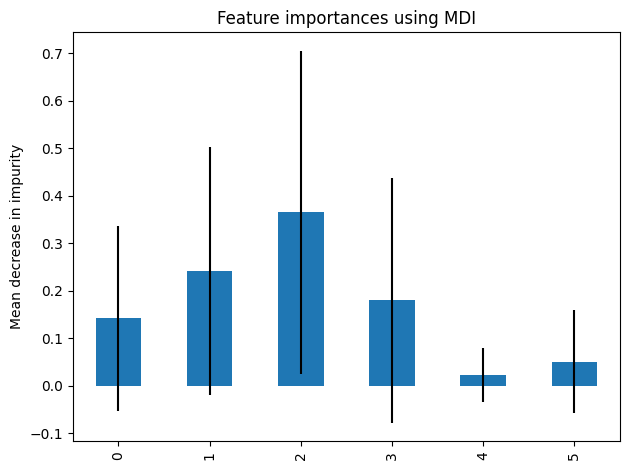

In [22]:

importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ 
              for tree in best_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=data_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4. Extreme Gradient Boosting - XGBoost

In [23]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100, verbosity = 0)

param_grid = {'max_depth': range(4, 40),
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.6, 0.9, 0.95, 0.99],
             'n_estimators': range(100, 1100, 100),
             'min_child_weight': range(1, 11),
             'subsample': np.arange(0.1, 1.1, 0.1),
             'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object 
xgb_grid = RandomizedSearchCV(xgb, param_grid, cv = 5) 
    
# fitting the model for grid search 
xgb_grid = xgb_grid.fit(X_train, y_train.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", xgb_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", xgb_grid.best_estimator_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.5}

Best Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...)


In [24]:
# XG Boost with Best Hypertuned Parameters
best_xgb = xgb_grid.best_estimator_
best_xgb.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...)

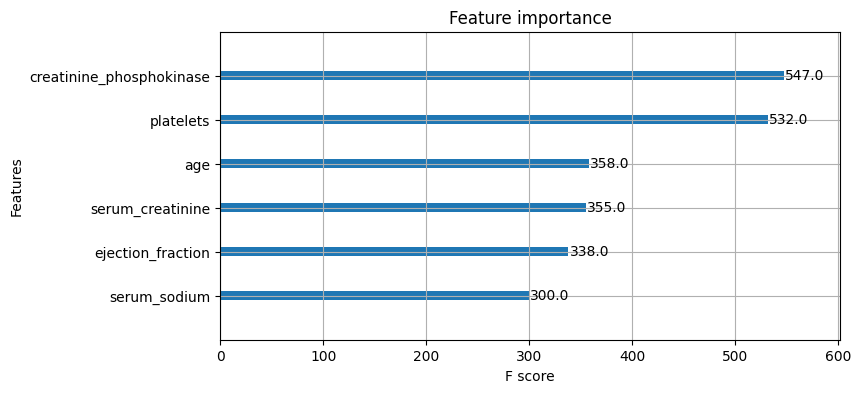

In [26]:
# plot_model_feature_importances(model = best_xgb) # this throws an error sometimes - 
# AttributeError: 'XGBClassifier' object has no attribute 'feature_importances_'
# XGBoostError: need to call fit or 'load_model' beforehand

from xgboost import plot_importance

ax = plot_importance(best_xgb)

# # get the original names back
yticklabels = list(ax.get_yticklabels())
dict_features = dict(enumerate(data_features))
lst_yticklabels = [ yticklabels[i].get_text().lstrip('f') for i in range(len(yticklabels))]
lst_yticklabels = [ data_features[int(i)] for i in lst_yticklabels]

ax.set_yticklabels(lst_yticklabels)
ax.figure.set_size_inches(8, 4)
plt.show()

### <font color = Green>Shap Summary Plot</font>

[21:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


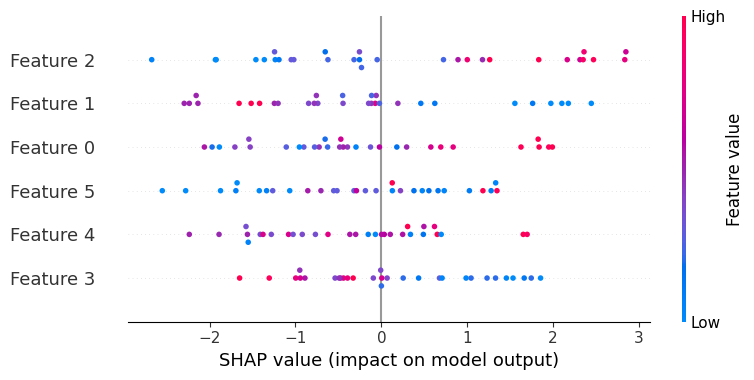

In [27]:

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### <font color = Red>Insight:</font>

1. **Serum_Creatinine**: Many bright red dot cluster (high values) are seen around the [1 - 3] range in the x-axis. This means increase in value of serum_creatinine nearly doubles/triples the risk of death.
2. **Ejection_Fraction**: Though majority of subjects have ejection fraction around the normal range, a few have extremely low values, within the [1 - 3] range in the x-axis. This indicates lower than normal values of ejection_fraction nearly doubles/triples the risk of death.
3. **Age**: A few red dot cluster (high values) are seen around the [1 - 3] range in the x-axis. This means with increase in age the risk of death due to heart failure condition nearly doubles/triples.

[21:59:56] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[21:59:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


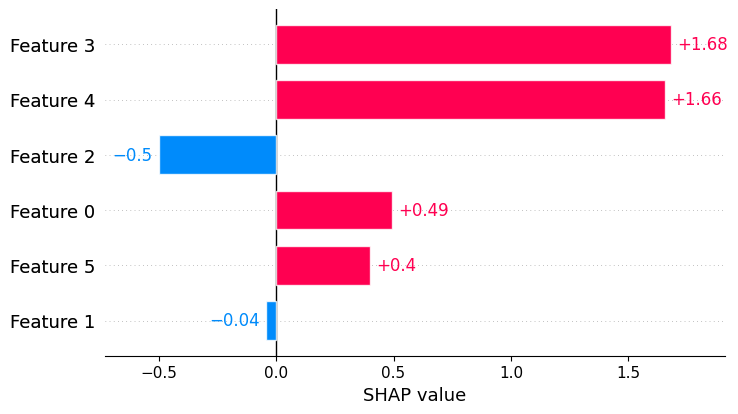

In [28]:
# compute SHAP values

explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_train)
shap.plots.bar(shap_values[0])

### <font color = Red>Insight:</font>

**serum_creatinine**, **ejection_fraction**, and **age** turn out to be most important features and the death event is highly dependent on these parameters.